imports

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

Load raw dataframes

In [2]:
shape_df = gpd.read_file('data/Output_Areas_2021_EW_BGC_V2_-6371128854279904124/OA_2021_EW_BGC_V2.shp')
crime_df = pd.read_csv('data/curated_data/crime.csv')
income_df = pd.read_excel('data/demographic_data/saiefy1920finalqaddownload280923.xlsx', sheet_name='Total annual income')
lsoa_df = gpd.read_file('data/London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')
surveys = pd.read_excel('data/PAS_T&Cdashboard_to Q3 23-24.xlsx', sheet_name='Borough')
outcomes_df = pd.read_csv('data/curated_data/outcome.csv')
stop_n_search_df = pd.read_csv('data/curated_data/stop_and_search.csv')

--- 

# Data Preprocessing

### Getting coordinates and bounding boxes for boroughs in the crimes_df

In [3]:
# helper function to get the district name from the LSOA name
def get_district_name(lsoa_name):
    # print(lsoa_name)
    if pd.isna(lsoa_name):
        return 'Not identified'
    return ' '.join(lsoa_name.split()[:-1])

crime_df['District'] = crime_df['LSOA name'].apply(get_district_name)

# standardize the names of the districts
crime_df['District'] = crime_df['District'].str.title()
lsoa_df['DISTRICT'] = lsoa_df['DISTRICT'].str.title()

# Rename 'City And County Of The City Of London' to 'City Of London'
# And 'City Of Westminster' to 'Westminster' in lsoa_df (geopandas)
lsoa_df['DISTRICT'] = lsoa_df['DISTRICT'].replace('City And County Of The City Of London', 'City Of London')
lsoa_df['DISTRICT'] = lsoa_df['DISTRICT'].replace('City Of Westminster', 'Westminster')

# shrink crimes df to only include the boroughs in the geopandas df
crime_df = crime_df[crime_df['District'].isin(lsoa_df['DISTRICT'])]

# Create a boroughs_df by dissolving the lsoa_df by the DISTRICT column
boroughs_df = lsoa_df.dissolve(by='DISTRICT')

# keep only required columns from boroughs_df
boroughs_df['District'] = boroughs_df.index
boroughs_df = boroughs_df[['District', 'geometry']]

# merge the two dataframes on 'District'
crimes_boroughs_df = pd.merge(crime_df, boroughs_df, on='District')

### Merge crimes and outcomes data

In [16]:
outcomes_df = pd.read_csv('data/curated_data/outcome.csv')
outcomes_df = outcomes_df[['Crime ID', 'Outcome type']]

# merge the two dataframes on 'Crime ID'
crimes_outcomes_df = pd.merge(crimes_boroughs_df, outcomes_df, on='Crime ID')

### Also merge income dataframe

In [45]:
income_df = pd.read_excel('data/demographic_data/saiefy1920finalqaddownload280923.xlsx', sheet_name='Total annual income')
income_df.columns = income_df.iloc[3].values
income_df = income_df[4:]

# keep only needed columns
income_df = income_df[['Local authority name', 'Total annual income (£)',
       'Upper confidence limit (£)', 'Lower confidence limit (£)',
       'Confidence interval (£)']]

income_df['Local authority name'] = income_df['Local authority name'].str.title()
# rename 'Local authority name' to 'District' in income_df
income_df = income_df.rename(columns={'Local authority name': 'District'})
# group by 'District' and take the mean of the income columns
income_df = income_df.groupby('District').mean().reset_index()

# merge the two dataframes on 'District'
crimes_income_df = pd.merge(crimes_outcomes_df, income_df, on='District')

---

### Merge ethnicity data

In [48]:
ethnicity_df = pd.read_excel("data/datadownload.xlsx")

In [51]:
ethnicity_df.columns = ethnicity_df.iloc[3].values
ethnicity_df = ethnicity_df.iloc[4:]

In [54]:
ethnicity_df['Area name'] = ethnicity_df['Area name'].str.title()
ethnicity_df = ethnicity_df.rename(columns={'Area name':'District'})

crimes_ethnicity_df = crimes_income_df.merge(ethnicity_df, on='District')

/var/folders/vw/rm1q12851jq6ww7xsgf4g0x00000gn/T/ipykernel_29626/3909631879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ethnicity_df['Area name'] = ethnicity_df['Area name'].str.title()


---

### Lastly add religious data to the dataset

In [80]:
religion_df = pd.read_excel("data/religion.xlsx")

In [81]:
religion_df.columns = religion_df.iloc[3].values
religion_df = religion_df.iloc[4:]


In [82]:
religion_df['Area name'] = religion_df['Area name'].str.title()
religion_df = religion_df.rename(columns={'Area name':'District'})
# religion_df['District'] = religion_df['District'].str.title

crime_religion_df = crimes_ethnicity_df.merge(religion_df, on='District')

In [84]:
crime_religion_df.shape

(2531977, 77)

# Visualizations

### Chloropleth map of crime counts

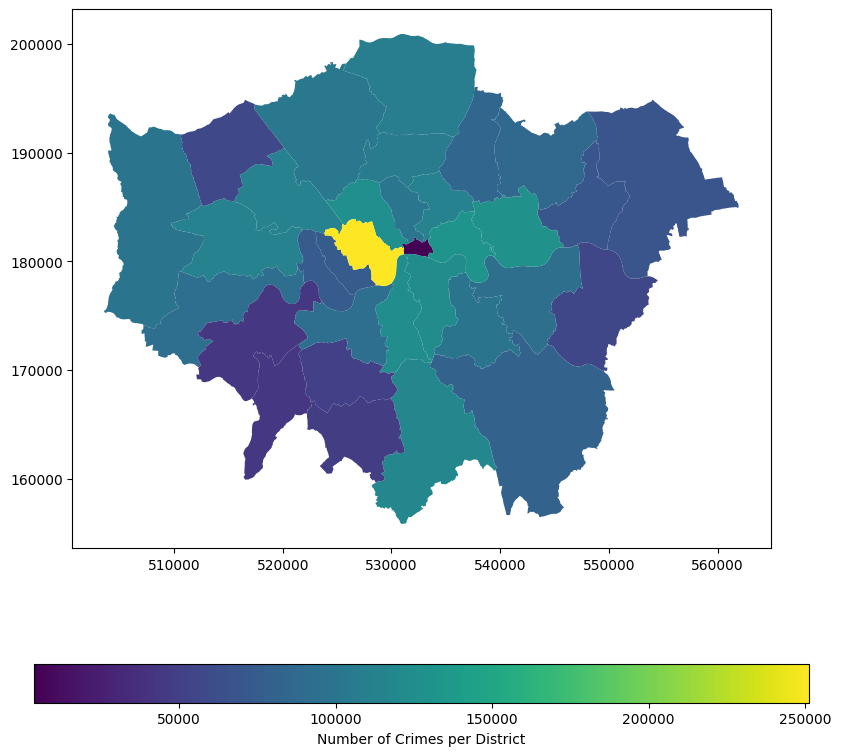

In [6]:
crime_counts = crimes_boroughs_df.groupby('District').size().reset_index(name='Crime Count')
lsoa_df = lsoa_df.dissolve(by='DISTRICT')
lsoa_df['District'] = lsoa_df.index
lsoa_df.reset_index(drop=True, inplace=True)
choropleth_data = lsoa_df.merge(crime_counts, on='District')

# Create the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
choropleth_data.plot(column='Crime Count', ax=ax, legend=True,
                     legend_kwds={'label': "Number of Crimes per District",
                                  'orientation': "horizontal"})
plt.show()

---

### Read the survey file

In [85]:
surveys = pd.read_excel('data/PAS_T&Cdashboard_to Q3 23-24.xlsx', sheet_name='Borough')

In [90]:
survey_boroughs = surveys['Borough'].unique().tolist()

In [95]:
[b.title() for b in survey_boroughs if b not in [i.title() for i in boroughs]]

['Barking And Dagenham',
 'Hammersmith And Fulham',
 'Kensington And Chelsea',
 'Kingston Upon Thames',
 'Richmond Upon Thames',
 'City Of Westminster']

In [97]:
crime_religion_df.shape

(2531977, 77)

In [98]:
crime_religion_df.columns

Index(['Crime ID', 'Month', 'Reported by', 'Falls within', 'Longitude',
       'Latitude', 'Location', 'LSOA code', 'LSOA name', 'Crime type',
       'Last outcome category', 'Context', 'District', 'geometry',
       'Outcome type', 'Total annual income (£)', 'Upper confidence limit (£)',
       'Lower confidence limit (£)', 'Confidence interval (£)', 'Area code_x',
       'Asian, Asian British or Asian Welsh: Bangladeshi\n(number)',
       'Asian, Asian British or Asian Welsh: Chinese\n(number)',
       'Asian, Asian British or Asian Welsh: Indian\n(number)',
       'Asian, Asian British or Asian Welsh: Pakistani\n(number)',
       'Asian, Asian British or Asian Welsh: Other Asian\n(number)',
       'Black, Black British, Black Welsh, Caribbean or African: African\n(number)',
       'Black, Black British, Black Welsh, Caribbean or African: Caribbean\n(number)',
       'Black, Black British, Black Welsh, Caribbean or African: Other Black\n(number)',
       'Mixed or Multiple ethnic gro